# PySpark Air Traffic Analysis and Regression Modeling

## Environment Setup and Data Loading

In [1]:
# Install Java 11 (required for PySpark)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Set environment variables for Java
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

In [2]:
# Install PySpark
!pip install pyspark

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [5]:
# Create Spark session
spark = SparkSession.builder \
    .appName("Air Traffic Analysis") \
    .getOrCreate()

In [6]:
# Load dataset
csv_path = "/content/drive/MyDrive/Colab Notebooks/PROYECTO_FINAL/Air_Traffic_Passenger_Statistics.csv"
df_spark = spark.read.csv(csv_path, header=True, inferSchema=True)

print("Dataset loaded successfully")
df_spark.printSchema()

Dataset loaded successfully
root
 |-- Activity Period: integer (nullable = true)
 |-- Operating Airline: string (nullable = true)
 |-- Operating Airline IATA Code: string (nullable = true)
 |-- Published Airline: string (nullable = true)
 |-- Published Airline IATA Code: string (nullable = true)
 |-- GEO Summary: string (nullable = true)
 |-- GEO Region: string (nullable = true)
 |-- Activity Type Code: string (nullable = true)
 |-- Price Category Code: string (nullable = true)
 |-- Terminal: string (nullable = true)
 |-- Boarding Area: string (nullable = true)
 |-- Passenger Count: integer (nullable = true)
 |-- Adjusted Activity Type Code: string (nullable = true)
 |-- Adjusted Passenger Count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)



## Cassandra-Inspired Analysis (Air China and Air Berlin)

In [7]:
print("=== CASSANDRA-INSPIRED ANALYSIS ===")

# A) Retrieve all records from "Air China" airline
air_china_count = df_spark.filter(df_spark["Operating Airline"] == "Air China").count()
print(f"Total Air China records: {air_china_count}")

# Display sample records
print("Sample Air China records:")
df_spark.filter(df_spark["Operating Airline"] == "Air China").show(10)

# B) Retrieve all "Air Berlin" flights from boarding gate "G"
air_berlin_g_count = df_spark.filter(
    (df_spark["Operating Airline"] == "Air Berlin") &
    (df_spark["Boarding Area"] == "G")
).count()

print(f"Total Air Berlin records at gate 'G': {air_berlin_g_count}")

# Display sample records
print("Sample Air Berlin gate 'G' records:")
df_spark.filter(
    (df_spark["Operating Airline"] == "Air Berlin") &
    (df_spark["Boarding Area"] == "G")
).show(10)


=== CASSANDRA-INSPIRED ANALYSIS ===
Total Air China records: 259
Sample Air China records:
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+---------+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|GEO Region|Activity Type Code|Price Category Code|     Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|    Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+---------+
|         200507|        Air China|                

## Basic Data Analysis

In [8]:
print("=== BASIC DATA ANALYSIS ===")

# Count unique airlines
unique_airlines = df_spark.select("Operating Airline").distinct()
print(f"Number of different airlines: {unique_airlines.count()}")

# Show top airlines by passenger count
df_spark.groupBy("Operating Airline") \
    .agg(sum("Adjusted Passenger Count").alias("Total_Passengers")) \
    .orderBy(desc("Total_Passengers")) \
    .show(20, truncate=False)

=== BASIC DATA ANALYSIS ===
Number of different airlines: 77
+--------------------------------+----------------+
|Operating Airline               |Total_Passengers|
+--------------------------------+----------------+
|United Airlines - Pre 07/01/2013|106333323       |
|United Airlines                 |64961880        |
|SkyWest Airlines                |35711773        |
|American Airlines               |34588714        |
|Virgin America                  |26934738        |
|Delta Air Lines                 |26446952        |
|Southwest Airlines              |25098015        |
|US Airways                      |16816616        |
|Alaska Airlines                 |13191073        |
|JetBlue Airways                 |7827973         |
|Air Canada                      |6680071         |
|Northwest Airlines              |6289321         |
|Lufthansa German Airlines       |4979907         |
|Frontier Airlines               |4624796         |
|British Airways                 |4547282         |
|Ca

## Data Cleaning

In [9]:
print("=== DATA CLEANING ===")

# Remove inconsistent airline entries
df_clean = df_spark.filter(
    (col("Operating Airline") != "United Airlines - Pre 07/01/2013") &
    (col("Published Airline") != "United Airlines - Pre 07/01/2013")
)

print(f"Records after cleaning: {df_clean.count()}")

# Calculate average passengers per airline
avg_passengers = df_clean.groupBy("Operating Airline") \
    .agg(round(avg(col("Passenger Count")), 2).alias("Average_Passengers")) \
    .orderBy(desc("Average_Passengers"))

print("Average passengers per airline:")
avg_passengers.show(20, truncate=False)

# Remove duplicates in GEO Region keeping highest passenger count
from pyspark.sql.window import Window

window = Window.partitionBy("GEO Region").orderBy(desc("Passenger Count"))
df_ranked = df_clean.withColumn("row_num", row_number().over(window))
unique_geo_regions = df_ranked.filter(col("row_num") == 1).drop("row_num")

print("Unique GEO Regions with highest passenger counts:")
unique_geo_regions.select("GEO Region", "Passenger Count").show()

=== DATA CLEANING ===
Records after cleaning: 12362
Average passengers per airline:
+-------------------------+------------------+
|Operating Airline        |Average_Passengers|
+-------------------------+------------------+
|American Airlines        |127164.39         |
|Southwest Airlines       |81188.16          |
|Virgin America           |74405.35          |
|United Airlines          |72732.06          |
|Delta Air Lines          |68498.5           |
|US Airways               |55317.82          |
|JetBlue Airways          |35261.14          |
|SkyWest Airlines         |27037.05          |
|Northwest Airlines       |26109.25          |
|Compass Airlines         |23358.56          |
|Lufthansa German Airlines|19301.97          |
|Air Canada               |18251.56          |
|Frontier Airlines        |17787.68          |
|British Airways          |17625.12          |
|Alaska Airlines          |17251.64          |
|Cathay Pacific           |17121.33          |
|Singapore Airlines    

## Export Results to CSV

In [10]:
print("=== EXPORTING RESULTS ===")

# Prepare data for export
avg_passengers_export = avg_passengers.withColumn("Result_Type", lit("Average Passengers per Airline"))
geo_regions_export = unique_geo_regions.withColumn("Result_Type", lit("Unique GEO Regions"))

# Combine results
combined_results = avg_passengers_export.select("Operating Airline", "Average_Passengers", "Result_Type") \
    .union(geo_regions_export.select("GEO Region", "Passenger Count", "Result_Type"))

# Export to CSV
combined_results.coalesce(1).write.mode("overwrite").csv(
    "/content/drive/MyDrive/Colab Notebooks/PROYECTO_FINAL/results/analysis_results",
    header=True
)

print("Results exported successfully")

=== EXPORTING RESULTS ===
Results exported successfully


## Descriptive Statistical Analysis

In [11]:
print("=== DESCRIPTIVE STATISTICAL ANALYSIS ===")

# Convert Month to numeric for analysis
df_numeric = df_clean.withColumn("Month_Numeric",
    when(col("Month") == "January", 1)
    .when(col("Month") == "February", 2)
    .when(col("Month") == "March", 3)
    .when(col("Month") == "April", 4)
    .when(col("Month") == "May", 5)
    .when(col("Month") == "June", 6)
    .when(col("Month") == "July", 7)
    .when(col("Month") == "August", 8)
    .when(col("Month") == "September", 9)
    .when(col("Month") == "October", 10)
    .when(col("Month") == "November", 11)
    .when(col("Month") == "December", 12)
    .otherwise(0)
)

# Statistical analysis by different categories
categories = ["Month", "Year", "GEO Region", "GEO Summary", "Terminal", "Boarding Area"]

for category in categories:
    print(f"\n--- Mean and Standard Deviation by {category} ---")
    df_clean.groupBy(category).agg(
        round(avg(col("Adjusted Passenger Count")), 1).alias("Mean_Passengers"),
        round(stddev(col("Adjusted Passenger Count")), 1).alias("StdDev_Passengers")
    ).orderBy(desc("Mean_Passengers")).show(10)

=== DESCRIPTIVE STATISTICAL ANALYSIS ===

--- Mean and Standard Deviation by Month ---
+---------+---------------+-----------------+
|    Month|Mean_Passengers|StdDev_Passengers|
+---------+---------------+-----------------+
|   August|        28342.7|          53347.7|
|     July|        28324.2|          52714.7|
|     June|        27235.8|          47376.1|
|  October|        25709.3|          49533.3|
|      May|        25613.8|          44532.6|
|    March|        25186.2|          44710.8|
| December|        24894.4|          47202.2|
|September|        24767.2|          47002.8|
|    April|        24256.9|          42117.9|
| November|        23999.9|          45684.2|
+---------+---------------+-----------------+
only showing top 10 rows


--- Mean and Standard Deviation by Year ---
+----+---------------+-----------------+
|Year|Mean_Passengers|StdDev_Passengers|
+----+---------------+-----------------+
|2014|        34470.1|          63681.9|
|2015|        34292.5|          62

## Correlation Analysis

In [12]:
print("=== CORRELATION ANALYSIS ===")

# Select only numeric columns for correlation
numeric_columns = ['Activity Period', 'Passenger Count', 'Adjusted Passenger Count', 'Year', 'Month_Numeric']

# Create feature vector
assembler_corr = VectorAssembler(inputCols=numeric_columns, outputCol="features_corr")
df_vector = assembler_corr.transform(df_numeric).select("features_corr")

# Calculate correlation matrix
corr_matrix = Correlation.corr(df_vector, "features_corr").head()[0].toArray()

# Extract top correlations
correlations = []
n = len(numeric_columns)
for i in range(n):
    for j in range(i + 1, n):
        correlations.append((numeric_columns[i], numeric_columns[j], float(corr_matrix[i, j])))

# Create DataFrame for results
corr_df = spark.createDataFrame(correlations, ["Variable_1", "Variable_2", "Correlation"])
corr_df = corr_df.withColumn("abs_corr", abs(col("Correlation")))

print("Top 10 strongest correlations:")
corr_df.orderBy(col("abs_corr").desc()).select("Variable_1", "Variable_2", "Correlation").show(10, truncate=False)

=== CORRELATION ANALYSIS ===
Top 10 strongest correlations:
+------------------------+------------------------+--------------------+
|Variable_1              |Variable_2              |Correlation         |
+------------------------+------------------------+--------------------+
|Passenger Count         |Adjusted Passenger Count|0.9999720033860299  |
|Activity Period         |Year                    |0.999942411545327   |
|Activity Period         |Passenger Count         |0.13786653179116015 |
|Passenger Count         |Year                    |0.13748933667462143 |
|Activity Period         |Adjusted Passenger Count|0.1373897497334747  |
|Adjusted Passenger Count|Year                    |0.13701340006287793 |
|Year                    |Month_Numeric           |-0.12415121830289737|
|Activity Period         |Month_Numeric           |-0.11349520193248305|
|Passenger Count         |Month_Numeric           |0.018537791569457347|
|Adjusted Passenger Count|Month_Numeric           |0.01851617619

## Data Preparation for Machine Learning

In [13]:
print("=== DATA PREPARATION FOR MACHINE LEARNING ===")

# Handle missing values
missing_counts = df_clean.select([sum(col(c).isNull().cast("integer")).alias(c) for c in df_clean.columns])
print("Missing values per column:")
missing_counts.show()

# Fill missing IATA codes with mode
operating_iata_mode = df_clean.groupBy("Operating Airline IATA Code") \
    .agg(count("*").alias("count")) \
    .orderBy(desc("count")) \
    .first()[0]

published_iata_mode = df_clean.groupBy("Published Airline IATA Code") \
    .agg(count("*").alias("count")) \
    .orderBy(desc("count")) \
    .first()[0]

df_filled = df_clean.fillna({
    "Operating Airline IATA Code": operating_iata_mode,
    "Published Airline IATA Code": published_iata_mode
})

# Remove duplicates
df_final = df_filled.dropDuplicates()

print(f"Final dataset size: {df_final.count()} records")

=== DATA PREPARATION FOR MACHINE LEARNING ===
Missing values per column:
+---------------+-----------------+---------------------------+-----------------+---------------------------+-----------+----------+------------------+-------------------+--------+-------------+---------------+---------------------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|GEO Summary|GEO Region|Activity Type Code|Price Category Code|Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-----------+----------+------------------+-------------------+--------+-------------+---------------+---------------------------+------------------------+----+-----+
|              0|                0|                         54|                0|                     

## Feature Engineering and Model Preparation

In [14]:
print("=== FEATURE ENGINEERING ===")

# Add numeric month column
df_model = df_final.withColumn("Month_Numeric",
    when(col("Month") == "January", 1)
    .when(col("Month") == "February", 2)
    .when(col("Month") == "March", 3)
    .when(col("Month") == "April", 4)
    .when(col("Month") == "May", 5)
    .when(col("Month") == "June", 6)
    .when(col("Month") == "July", 7)
    .when(col("Month") == "August", 8)
    .when(col("Month") == "September", 9)
    .when(col("Month") == "October", 10)
    .when(col("Month") == "November", 11)
    .when(col("Month") == "December", 12)
    .otherwise(0)
)

# Select features for modeling
selected_features = [
    "Adjusted Passenger Count",  # Target variable
    "Operating Airline",
    "Month_Numeric",
    "GEO Region",
    "Activity Type Code",
    "Terminal",
    "Published Airline",
    "Year",
    "Boarding Area"
]

df_model = df_model.select(*selected_features).filter(col("Adjusted Passenger Count").isNotNull())

# Define categorical and numeric columns
categorical_cols = ["Operating Airline", "GEO Region", "Activity Type Code", "Terminal", "Published Airline", "Boarding Area"]
numeric_cols = ["Month_Numeric", "Year"]

print(f"Categorical features: {len(categorical_cols)}")
print(f"Numeric features: {len(numeric_cols)}")

=== FEATURE ENGINEERING ===
Categorical features: 6
Numeric features: 2


## Pipeline Creation and Data Transformation

In [15]:
print("=== PIPELINE CREATION ===")

# Create transformation pipeline
indexers = []
encoders = []
encoded_cols = []

for col_name in categorical_cols:
    # String indexer
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_indexed", handleInvalid="skip")
    indexers.append(indexer)

    # One-hot encoder
    encoder = OneHotEncoder(inputCol=col_name + "_indexed", outputCol=col_name + "_encoded")
    encoders.append(encoder)
    encoded_cols.append(col_name + "_encoded")

# Feature assembler
feature_cols = numeric_cols + encoded_cols
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

# Complete pipeline
pipeline_stages = indexers + encoders + [assembler]
preprocessing_pipeline = Pipeline(stages=pipeline_stages)

# Apply transformations
df_processed = preprocessing_pipeline.fit(df_model).transform(df_model)

# Train-test split
train_data, test_data = df_processed.randomSplit([0.8, 0.2], seed=42)
print(f"Training set: {train_data.count()} records")
print(f"Test set: {test_data.count()} records")

=== PIPELINE CREATION ===
Training set: 9939 records
Test set: 2423 records


## Model Training with Grid Search and Cross Validation

In [16]:
print("=== MODEL TRAINING ===")

# Define evaluators
evaluator_rmse = RegressionEvaluator(labelCol="Adjusted Passenger Count", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="Adjusted Passenger Count", predictionCol="prediction", metricName="r2")

# Decision Tree with Grid Search
print("Training Decision Tree...")
dt = DecisionTreeRegressor(featuresCol="features", labelCol="Adjusted Passenger Count")

param_grid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [10, 20]) \
    .addGrid(dt.minInstancesPerNode, [10, 50]) \
    .build()

crossval_dt = CrossValidator(
    estimator=dt,
    estimatorParamMaps=param_grid_dt,
    evaluator=evaluator_rmse,
    numFolds=3,
    seed=42
)

cv_model_dt = crossval_dt.fit(train_data)
best_dt_model = cv_model_dt.bestModel

print(f"Best Decision Tree parameters:")
print(f"- maxDepth: {best_dt_model.getMaxDepth()}")
print(f"- minInstancesPerNode: {best_dt_model.getMinInstancesPerNode()}")

# Random Forest with Grid Search
print("Training Random Forest...")
rf = RandomForestRegressor(featuresCol="features", labelCol="Adjusted Passenger Count", seed=42)

param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [10, 15]) \
    .build()

crossval_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid_rf,
    evaluator=evaluator_rmse,
    numFolds=3,
    seed=42
)

cv_model_rf = crossval_rf.fit(train_data)
best_rf_model = cv_model_rf.bestModel

print(f"Best Random Forest parameters:")
print(f"- numTrees: {best_rf_model.getNumTrees}")
print(f"- maxDepth: {best_rf_model.getMaxDepth()}")

=== MODEL TRAINING ===
Training Decision Tree...
Best Decision Tree parameters:
- maxDepth: 20
- minInstancesPerNode: 10
Training Random Forest...
Best Random Forest parameters:
- numTrees: 100
- maxDepth: 15


## Model Evaluation and Comparison

In [17]:
print("=== MODEL EVALUATION ===")

# Evaluate Decision Tree
train_pred_dt = best_dt_model.transform(train_data)
test_pred_dt = best_dt_model.transform(test_data)

train_rmse_dt = evaluator_rmse.evaluate(train_pred_dt)
test_rmse_dt = evaluator_rmse.evaluate(test_pred_dt)
train_r2_dt = evaluator_r2.evaluate(train_pred_dt)
test_r2_dt = evaluator_r2.evaluate(test_pred_dt)

# Evaluate Random Forest
train_pred_rf = best_rf_model.transform(train_data)
test_pred_rf = best_rf_model.transform(test_data)

train_rmse_rf = evaluator_rmse.evaluate(train_pred_rf)
test_rmse_rf = evaluator_rmse.evaluate(test_pred_rf)
train_r2_rf = evaluator_r2.evaluate(train_pred_rf)
test_r2_rf = evaluator_r2.evaluate(test_pred_rf)

# Create comparison DataFrame
models_comparison = [
    ("Decision Tree", train_rmse_dt, test_rmse_dt, train_r2_dt, test_r2_dt),
    ("Random Forest", train_rmse_rf, test_rmse_rf, train_r2_rf, test_r2_rf)
]

df_comparison = spark.createDataFrame(models_comparison, ["Model", "Train_RMSE", "Test_RMSE", "Train_R2", "Test_R2"])
df_comparison = df_comparison.orderBy("Test_RMSE")

print("Model Comparison Results:")
df_comparison.show(truncate=False)

# Select best model
best_model_row = df_comparison.first()
best_model_name = best_model_row["Model"]
best_rmse = best_model_row["Test_RMSE"]
best_r2 = best_model_row["Test_R2"]

print(f"\nBest Model: {best_model_name}")
print(f"Test RMSE: {best_rmse:.1f}")
print(f"Test R²: {best_r2:.3f}")
print(f"Variance explained: {best_r2 * 100:.1f}%")

=== MODEL EVALUATION ===
Model Comparison Results:
+-------------+------------------+------------------+------------------+------------------+
|Model        |Train_RMSE        |Test_RMSE         |Train_R2          |Test_R2           |
+-------------+------------------+------------------+------------------+------------------+
|Decision Tree|10729.960115861943|9954.597972699583 |0.9464235901788447|0.9538902124276072|
|Random Forest|15927.465541918886|14829.816385767592|0.8819487089509778|0.8976666435966785|
+-------------+------------------+------------------+------------------+------------------+


Best Model: Decision Tree
Test RMSE: 9954.6
Test R²: 0.954
Variance explained: 95.4%


## Visualization and Results Export

=== GENERATING VISUALIZATIONS ===


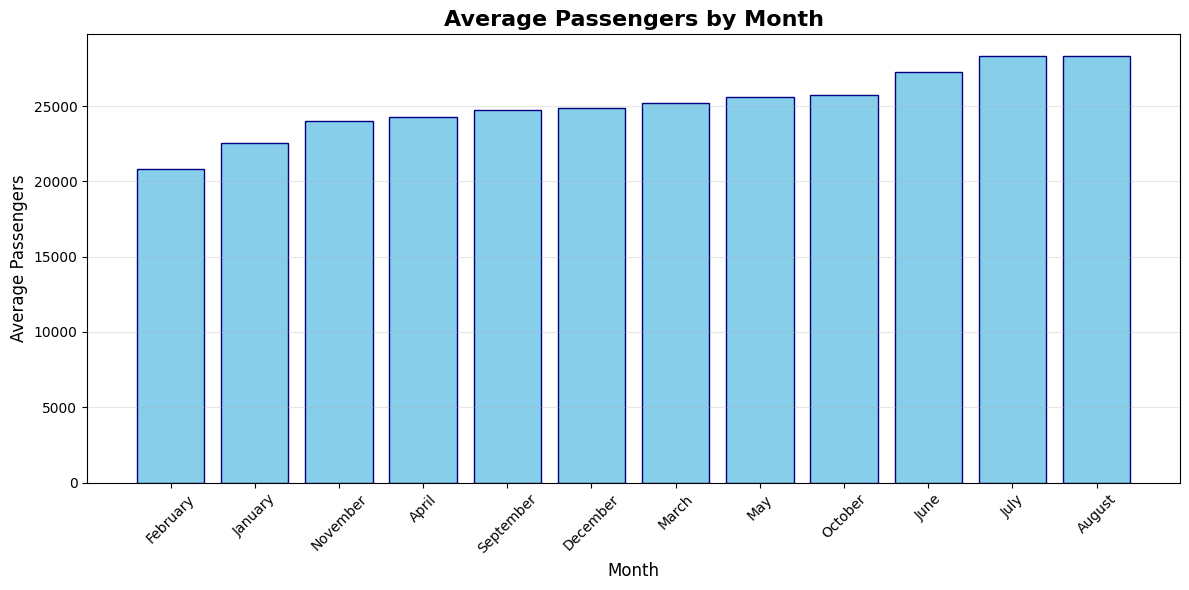

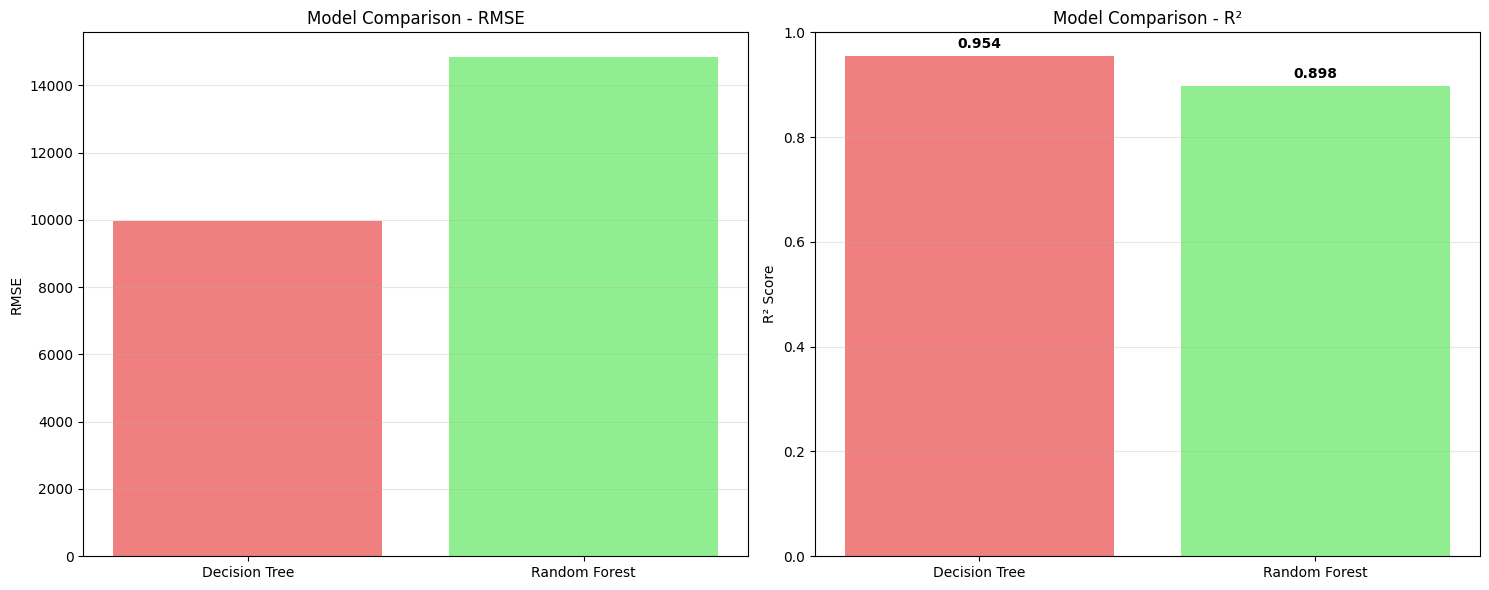

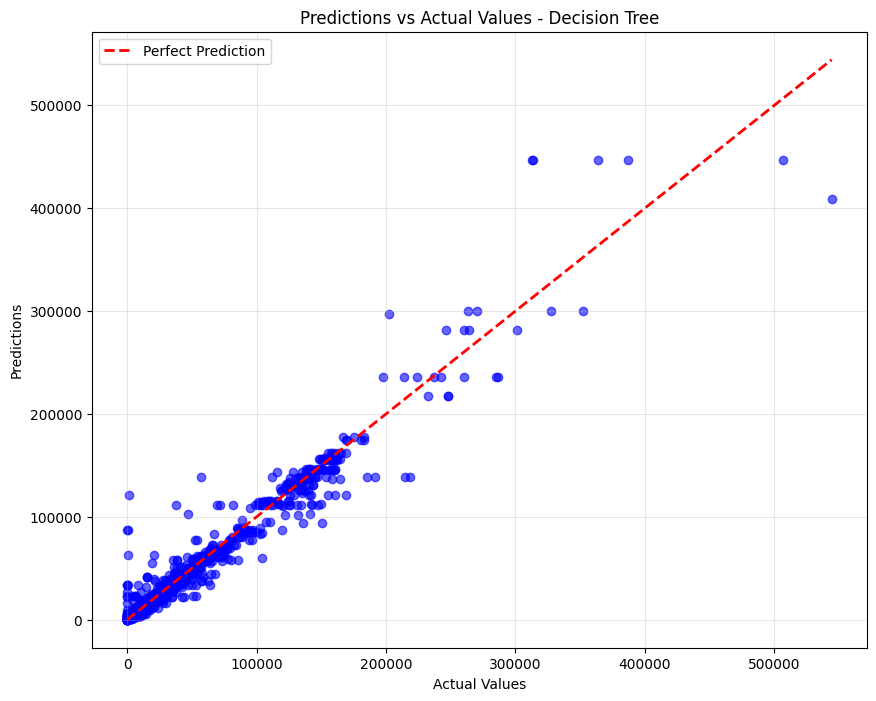

In [18]:
print("=== GENERATING VISUALIZATIONS ===")

# Convert sample data to Pandas for visualization
def spark_to_pandas_sample(spark_df, sample_size=5000):
    total_count = spark_df.count()
    if total_count > sample_size:
        fraction = sample_size / total_count
        return spark_df.sample(fraction=fraction, seed=42).toPandas()
    else:
        return spark_df.toPandas()

# Monthly passenger distribution
month_data = df_final.groupBy("Month") \
    .agg(avg("Adjusted Passenger Count").alias("Avg_Passengers")) \
    .orderBy("Avg_Passengers") \
    .toPandas()

plt.figure(figsize=(12, 6))
plt.bar(month_data['Month'], month_data['Avg_Passengers'], color='skyblue', edgecolor='navy')
plt.title('Average Passengers by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Passengers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Model comparison visualization
models = ['Decision Tree', 'Random Forest']
rmse_values = [test_rmse_dt, test_rmse_rf]
r2_values = [test_r2_dt, test_r2_rf]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# RMSE comparison
ax1.bar(models, rmse_values, color=['lightcoral', 'lightgreen'])
ax1.set_ylabel('RMSE')
ax1.set_title('Model Comparison - RMSE')
ax1.grid(axis='y', alpha=0.3)

# R² comparison
ax2.bar(models, r2_values, color=['lightcoral', 'lightgreen'])
ax2.set_ylabel('R² Score')
ax2.set_title('Model Comparison - R²')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

for i, v in enumerate(r2_values):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Predictions vs actual values
pred_sample = spark_to_pandas_sample(test_pred_dt.select("Adjusted Passenger Count", "prediction"), 3000)

plt.figure(figsize=(10, 8))
plt.scatter(pred_sample['Adjusted Passenger Count'], pred_sample['prediction'], alpha=0.6, color='blue')
plt.plot([pred_sample['Adjusted Passenger Count'].min(), pred_sample['Adjusted Passenger Count'].max()],
         [pred_sample['Adjusted Passenger Count'].min(), pred_sample['Adjusted Passenger Count'].max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs Actual Values - {best_model_name}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Final Results and Export

In [19]:
print("=== FINAL RESULTS SUMMARY ===")

# Calculate total passengers
total_passengers = df_final.select(sum("Adjusted Passenger Count").alias("Total")).collect()[0]["Total"]

print(f"Dataset Summary:")
print(f"- Total records processed: {df_final.count():,}")
print(f"- Total passengers analyzed: {total_passengers:,.0f}")
print(f"- Best performing model: {best_model_name}")
print(f"- Model accuracy (R²): {best_r2:.3f}")
print(f"- Average prediction error (RMSE): {best_rmse:.0f} passengers")

# Export final predictions
print("Exporting final results...")
test_pred_dt.select("Adjusted Passenger Count", "prediction") \
    .coalesce(1) \
    .write \
    .mode("overwrite") \
    .csv("/content/drive/MyDrive/Colab Notebooks/PROYECTO_FINAL/final_predictions", header=True)

print("✅ Analysis completed successfully!")
print("✅ Results exported to Google Drive")

=== FINAL RESULTS SUMMARY ===
Dataset Summary:
- Total records processed: 12,362
- Total passengers analyzed: 310,900,508
- Best performing model: Decision Tree
- Model accuracy (R²): 0.954
- Average prediction error (RMSE): 9955 passengers
Exporting final results...
✅ Analysis completed successfully!
✅ Results exported to Google Drive
